## 1. Load dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import cvxpy as cp
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.decomposition import KernelPCA

In [2]:
# Load UCI Digits dataset
digits = datasets.load_digits()
X, y = digits.data, digits.target
X = X[:100]

print(X.shape)


(100, 64)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate two-moon datasets
graph_number = 10
single_view_graph_X = []
for i in range(graph_number):
    X, y = make_moons(n_samples=100, noise=0.13, random_state=i+10)
    single_view_graph_X.append(X)
    

## 2. Algorithm

### 2.1 Single View Graph Learning

In [4]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from tqdm import tqdm 
import cvxpy as cp

def compute_laplacian(S):
    S_sym = (S.T + S) / 2  # Compute symmetric part
    D = np.diag(S_sym.sum(axis=0))  # Compute diagonal matrix D
    L = D - S_sym  # Compute Laplacian matrix
    return L

def update_Q(L, c):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    Q = eigenvectors[:, :c]
    return Q

def update_S(Q, beta): # equation (9)
    n, c = Q.shape
    S = np.zeros((n, n))
    
    for j in range(n):
        g_j = np.array([np.linalg.norm(Q[j] - Q[i])**2 for i in range(n)])
        intermediate = g_j / (2 * beta)
        eta = (1 + np.sum(intermediate)) / n
        s_j = np.maximum(0, -intermediate + eta)
        
        S[j] = s_j
    
    return S

def make_single_view_graph(single_view_graph_X, class_number, default_beta=1.0):
    
    single_view_graph = []
    
    for i in tqdm(range(len(single_view_graph_X))):
        
        # init
        beta = default_beta
        S = update_S(single_view_graph_X[i], beta)
        L = compute_laplacian(S)
        Q = update_Q(L, class_number)

        for j in range(100):
            S = update_S(Q, beta)
            L = compute_laplacian(S)
            Q = update_Q(L, class_number)

            L_rank = np.linalg.matrix_rank(L)
            # print("L_rank",L_rank, "beta", beta)
            if L_rank == X.shape[0] - class_number:
                tqdm.write(f"{i+1}th graph end at {j}th iteration, L's rank is {L_rank}")
                break
            elif L_rank > X.shape[0] - class_number:
                beta *= 0.9 
            else:
                beta *= 1.1
                
        single_view_graph.append(L)
        
    return single_view_graph


In [5]:
class_number = 2

single_view_graph = make_single_view_graph(single_view_graph_X, class_number)

 10%|█         | 1/10 [00:00<00:04,  2.12it/s]

1th graph end at 12th iteration, L's rank is 98


 20%|██        | 2/10 [00:01<00:04,  1.64it/s]

2th graph end at 14th iteration, L's rank is 98


 30%|███       | 3/10 [00:01<00:04,  1.71it/s]

3th graph end at 14th iteration, L's rank is 98


 40%|████      | 4/10 [00:02<00:03,  1.84it/s]

4th graph end at 11th iteration, L's rank is 98


 50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

5th graph end at 16th iteration, L's rank is 98


 60%|██████    | 6/10 [00:03<00:02,  1.69it/s]

6th graph end at 12th iteration, L's rank is 98


 70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

7th graph end at 10th iteration, L's rank is 98


 80%|████████  | 8/10 [00:04<00:01,  1.79it/s]

8th graph end at 16th iteration, L's rank is 98


 90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

9th graph end at 12th iteration, L's rank is 98


100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

10th graph end at 16th iteration, L's rank is 98


### 2.2 Global Graph Learning

In [6]:
def init_W(single_view_graph):
    W = [np.full(single_view_graph[0].shape, 1/len(single_view_graph))] * len(single_view_graph)
    return W

def init_A(single_view_graph, W):
    A = np.sum(single_view_graph, axis=0) * W[0]
    return A

def init_P(A,c):
    L = compute_laplacian(A)
    P = update_Q(L, c)
    return P

def update_A(P, w_list, s_list, gamma=1.0):
    n = P.shape[0]
    c = P.shape[1]
    m = len(w_list)

    H = np.sum((P[:, np.newaxis, :] - P)**2, axis=2)
    
    A = np.zeros((n, n))
    
    for j in range(c):
        h_j = H[:, j]
    
        sum_term = np.zeros(n)
        for v in range(m):
            w_jv = w_list[v][:, j]
            s_jv = s_list[v][:, j] 
            sum_term += w_jv * s_jv  
        intermediate = (((gamma / 2.0) * (h_j)) - sum_term)
        
    eta = (1 + np.sum(intermediate)) / n
    a_j = np.maximum(0, -intermediate + eta)
    
    A[j] = a_j

    return A


def update_P(L, c):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    Q = eigenvectors[:, :c]
    return Q


def compute_W(a, s_list):
    v, n, _ = np.shape(s_list) 
    w_list = []

    for i in range(v):
        wv = np.zeros((n, n)) 
        for j in range(n):
            Z_j = a[:,j] - s_list[i][:,j]
            Z_j = Z_j.reshape(1, -1) 
            ZTZ_inv = np.linalg.pinv(Z_j.T @ Z_j)  # (Z_j^T Z_j)^{-1}
            one_vector = np.ones((n, 1)) 
            w_jv = (ZTZ_inv @ one_vector) * (1 / (one_vector.T @ ZTZ_inv @ one_vector))
            wv[:,j] = w_jv.reshape(-1) / np.sum(w_jv)
        w_list.append(wv)

    return w_list

def make_global_graph(single_view_graph, class_number, default_gamma=1.0):
    
    # init
    W = init_W(single_view_graph)
    A = init_A(single_view_graph, W)
    P = init_P(A, class_number)
    gamma = default_gamma
    
    for j in tqdm(range(100)):
        A = update_A(P, W, single_view_graph)
        L = compute_laplacian(A)
        P = update_P(L, class_number)
        W = compute_W(A, single_view_graph)

        tqdm.write(f"iteration: {j}, L_rank: {np.linalg.matrix_rank(L)}, gamma: {gamma}")
        # print(sum(W[0][:,0]))
        L_rank = np.linalg.matrix_rank(L)
        if L_rank == X.shape[0] - class_number:
            tqdm.write(f"end at {j}th iteration, L's rank is {L_rank}")
            break
        elif L_rank < X.shape[0] - class_number:
            gamma *= 0.9 
        else:
            gamma *= 1.1
        
    return L

In [7]:
class_number = 2

global_graph = make_global_graph([single_view_graph[6],single_view_graph[8]], class_number)

  1%|          | 1/100 [00:00<01:31,  1.09it/s]

iteration: 0, L_rank: 52, gamma: 1.0


  2%|▏         | 2/100 [00:01<01:19,  1.23it/s]

iteration: 1, L_rank: 93, gamma: 0.9


  3%|▎         | 3/100 [00:02<01:30,  1.08it/s]

iteration: 2, L_rank: 99, gamma: 0.81


  4%|▍         | 4/100 [00:03<01:24,  1.13it/s]

iteration: 3, L_rank: 0, gamma: 0.8910000000000001


  5%|▌         | 5/100 [00:04<01:27,  1.09it/s]

iteration: 4, L_rank: 0, gamma: 0.8019000000000002


  6%|▌         | 6/100 [00:05<01:39,  1.06s/it]

iteration: 5, L_rank: 0, gamma: 0.7217100000000002


  6%|▌         | 6/100 [00:07<02:01,  1.29s/it]

iteration: 6, L_rank: 98, gamma: 0.6495390000000002
end at 6th iteration, L's rank is 98


### 2.3 Cluster by Laplacian matrix

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import laplacian

def cluster(laplacian, n_clusters):
    eigenvalues, eigenvectors = np.linalg.eigh(laplacian)
    X = eigenvectors[:, :n_clusters]
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    return kmeans.labels_

# get clustering results
single_view_graph_labels = []
for i in range(len(single_view_graph)):
    single_view_graph_labels.append(cluster(single_view_graph[i], class_number))

global_graph_labels = cluster(global_graph, class_number)
print(global_graph_labels)

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


# 3. Visualization

In [9]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from matplotlib.colors import ListedColormap


def plot_clusters_multi(X_list, labels_list, n_nearest=5):
    # Ensure the input lists are of the same length
    assert len(X_list) == len(labels_list), "X_list and labels_list must have the same number of elements"
    
    n_datasets = len(X_list)
    rows = int(np.ceil(np.sqrt(n_datasets)))
    cols = int(np.ceil(n_datasets / rows))
    
    plt.figure(figsize=(6 * cols, 4 * rows))
    
    for idx in range(n_datasets):
        X = X_list[idx]
        labels = labels_list[idx]
        
        # Compute nearest neighbor connections
        n = X.shape[0]
        D = np.linalg.norm(X[:, np.newaxis, :] - X, axis=2)
        S_new = np.zeros((n, n), dtype=int)
        for i in range(n):
            nearest_neighbors = np.argsort(D[i])[1:n_nearest+1]
            S_new[i, nearest_neighbors] = 1
        
        # Create subplot
        plt.subplot(rows, cols, idx + 1)
        colors = ['blue', 'red']
        cmap = ListedColormap(colors)
        
        # Plot data points
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap,
                    edgecolor='k', s=50, zorder=2)
        
        # Plot intra-cluster connections
        for i in range(n):
            for j in range(i + 1, n):
                if (S_new[i, j] or S_new[j, i]) and labels[i] == labels[j]:
                    plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]],
                             color=colors[labels[i]], alpha=0.4, zorder=1)
        
        plt.title(f'Graph {idx} ({n_nearest} NN)')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()

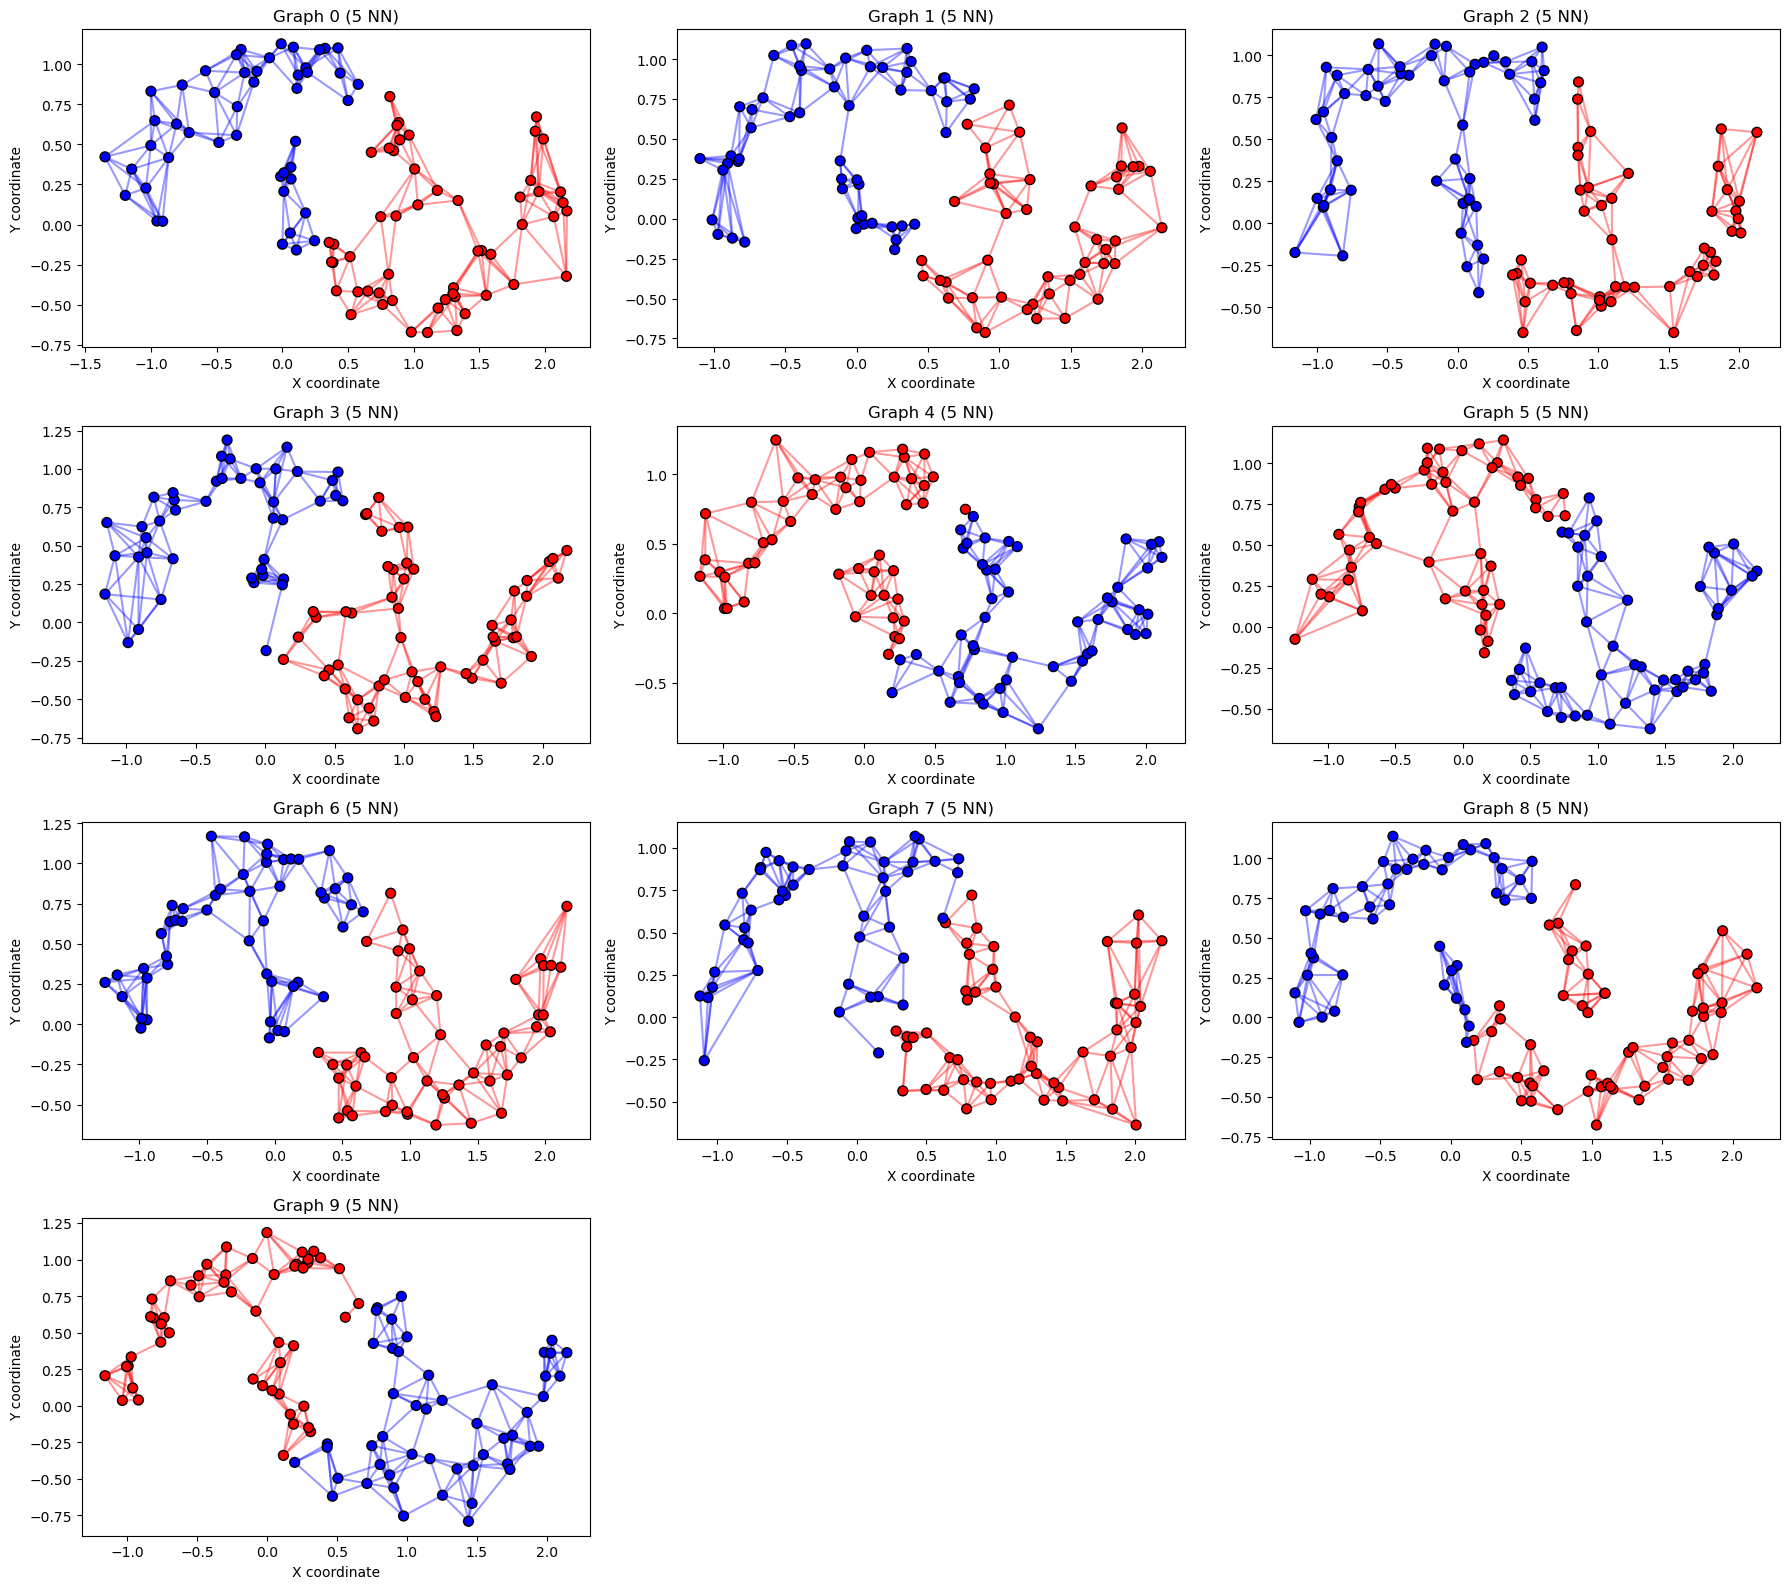

In [10]:
plot_clusters_multi(single_view_graph_X, single_view_graph_labels)

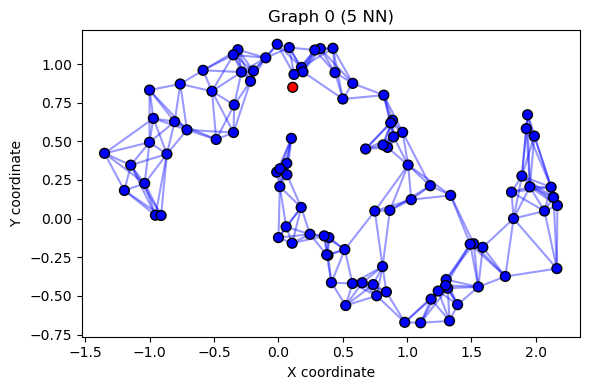

In [11]:
plot_clusters_multi([single_view_graph_X[0]], [global_graph_labels]) 

# 4. Evaluation

In [13]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix

def cluster_accuracy(y_true, y_pred):
    acc = np.mean(y_pred == y_true)
    return acc

def purity_score(y_true, y_pred):
    contingency = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

def pairwise_precision_recall_fscore(y_true, y_pred):

    def get_pairs(labels):
        pairs = set()
        for label in np.unique(labels):
            indices = np.where(labels == label)[0]
            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    pairs.add((indices[i], indices[j]))
        return pairs

    true_pairs = get_pairs(y_true)
    pred_pairs = get_pairs(y_pred)
    
    tp = len(true_pairs & pred_pairs)
    fp = len(pred_pairs - true_pairs)
    fn = len(true_pairs - pred_pairs)

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    return precision, recall, f_score

def evaluate_clustering(y_true, y_pred):
    
    # remapping 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    assert y_true.shape == y_pred.shape

    labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    cost_matrix = -contingency_matrix(y_true, y_pred)

    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_mapping = {pred_labels[col]: labels[row] for row, col in zip(row_ind, col_ind)}

    y_pred_mapped = np.array([best_mapping[label] for label in y_pred])

    # evaluate
    acc = cluster_accuracy(y_true, y_pred_mapped)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    purity = purity_score(y_true, y_pred_mapped)
    precision, recall, f_score = pairwise_precision_recall_fscore(y_true, y_pred_mapped)
    ari = adjusted_rand_score(y_true, y_pred_mapped)

    return {
        "ACC": acc,
        "NMI": nmi,
        "Purity": purity,
        "Precision": precision,
        "Recall": recall,
        "F-score": f_score,
        "ARI": ari
    }


# test
metrics = evaluate_clustering(y, global_graph_labels)
print(metrics)


{'ACC': 0.51, 'NMI': 0.018639764244343528, 'Purity': 0.51, 'Precision': 0.494949494949495, 'Recall': 0.98, 'F-score': 0.6577181208053691, 'ARI': 0.0}
